In [1]:
# !pip install progressbar
# !pip install contractions

# !pip install spacy
# !pip install gensim 
# !pip install torch==1.4.0 torchvision==0.5.0 -f https://download.pytorch.org/whl/cu100/torch_stable.html
# !pip install fastBPE regex requests sacremoses subword_nmt
# !pip install -q hydra-core
# !pip install tqdm

# !pip install textattack -q
# !pip install GPUtil

# !python -m spacy download en_core_web_sm
# !python -m spacy download en_core_web_lg
# !python -m textblob.download_corpora

# !wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
    
import warnings
warnings.filterwarnings('ignore')

import itertools
import sklearn
import io
import tqdm
from progressbar import ProgressBar

import pandas as pd
import numpy as np
from random import randint
import os
import re


import contractions
import unicodedata
# from wordcloud import wordcloud
# from textblob import TextBlob
import joblib

# Visualisation libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Deep Learning 
import tensorflow as tf
import keras
from keras.models import Model,Sequential

from keras.layers import Activation,Flatten,Dense,Embedding,Input,GlobalAveragePooling1D,GlobalMaxPool1D,Conv1D,MaxPooling1D,concatenate,SpatialDropout1D
from keras.layers import LSTM,GRU,Bidirectional, Dropout,Permute,multiply,Layer
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
import keras.backend as K

import torch
import tensorflow_hub as hub
import tokenization
from transformers import BertTokenizer
from transformers import TFBertModel,AutoTokenizer,BertForMaskedLM

# Used to standardise the date and undertake PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# Scikit-learn imports for data encoding and partitionning
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD as TSVD

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import (confusion_matrix,roc_auc_score, precision_recall_curve, auc,
                             roc_curve, recall_score,accuracy_score, classification_report, f1_score,
                             precision_recall_fscore_support, log_loss)

# Spacy imports
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

# Gensim Imports
import gensim.downloader
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

# NLTK 
from nltk import word_tokenize
from nltk.corpus import stopwords

# from textattack.augmentation import WordNetAugmenter,EmbeddingAugmenter

In [2]:
# ## Trick to delete file 
# os.remove("/kaggle/working/submission_simple_LSTM_model_multiclass.csv")
# os.remove("/kaggle/working/X_word2Vec.pkl")

# ## Delete folder
# shutil.rmtree("/kaggle/working/logs" )

## Trick to find if tensorboard in running locally and kill the port 
# ps -ef|grep tensorboard
# kill -9 <pid>

## Clear logs and start tensorboard on jupiter
# !rm -rf ./logs/ 
# %reload_ext tensorboard

In [3]:
def plot_class_distribution(field):
    print(field.value_counts())
    sns.countplot(x=field).set_title('Visualisation of the dataset class distribution')
    plt.show()
    
def data_cleaning(df):
    df["review"] = clean_sentences(df["review"],remove_stop_words=False)
    df = extract_most_uncommon_words(df)
    return df

def remove_accented_chars(x):
    x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return x

def clean_sentences(review,remove_stop_words=False):
    #Lower Case Conversion 
    review = review.apply(lambda x: str(x).lower())
    # Contraction to Expansion 
    review = review.apply(lambda x: contractions.fix(str(x)))
    # Remove Emails and URL's from strings
    review = review.apply(lambda x: re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x))
    review = review.apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x))
    # Remove HTML tags
    review = review.apply(lambda x: re.sub('<.*?>',"",x))
    # Remove trailing whitespace
    review = review.apply(lambda x: ' '.join(x.split()))
    # Remove special characters and punctuation
    review = review.apply(lambda x: re.sub(r'[^\w ]+', "", x))
    # Remove accented characters
    review = review.apply(lambda x: remove_accented_chars(x))
    if remove_stop_words is True:
        # Remove Stop Words 
        review = review.apply(lambda x: ' '.join([t for t in x.split() if t not in stopwords]))
    return review

def extract_most_uncommon_words(df):
    text = ' '.join(df["review"])
    text = text.split()
    freq_comm = pd.Series(text).value_counts()
    uncommon_words= freq_comm[freq_comm == 1]
    df['review'] = df['review'].apply(lambda x: ' '.join([t for t in x.split() if t not in uncommon_words]))
    return df

def apply_TSVD(X_train,X_test,plot):
    tsvd = TSVD(n_components=9000, random_state=0)
    print('Initial train matrix shape is: ', X_train.shape)
    print('Initial test shape is: ', X_test.shape)
    X_train = tsvd.fit_transform(X_train)
    X_test = tsvd.transform(X_test)
    print('PCA transformed train shape is: ', X_train.shape)
    print('PCA transformed test shape is: ', X_test.shape)
    if plot is True:
        plt.plot(np.cumsum(tsvd.explained_variance_ratio_))
        plt.show()
    return X_train,X_test,tsvd

def back_translation_augmentation(X_train,y_train):
    class0_rev=[]
    class0_sen=[]
    
    class1_rev=[]
    class1_sen=[]
    
    class3_rev=[]
    class3_sen=[]
    
    class4_rev=[]
    class4_sen=[]
    
    augmenter = WordNetAugmenter()
    
    data=pd.DataFrame(X_train)
    data['sentiment']= y_train
    data = data.reset_index(drop=True)    
    df_class_0_threshold = int(len(data[data["sentiment"]==0]))
    df_class_1_threshold = int(len(data[data["sentiment"]==1])/2)
    df_class_2_threshold = int(len(data[data["sentiment"]==2]))
    df_class_3_threshold = int(len(data[data["sentiment"]==3])/2)
    df_class_4_threshold = int(len(data[data["sentiment"]==4]))


    data["review"] = clean_sentences(data["review"],remove_stop_words=False)
    
    df_class_0 = data[data["sentiment"]==0].reset_index(drop=True)    
    df_class_1 = data[data["sentiment"]==1].reset_index(drop=True)
    df_class_2 = data[data["sentiment"]==2].reset_index(drop=True)
    df_class_3 = data[data["sentiment"]==3].reset_index(drop=True)
    df_class_4 = data[data["sentiment"]==4].reset_index(drop=True)
        
    backTranslation = True

    try:
        # torch.hub.list('pytorch/fairseq')  # [..., 'transformer.wmt16.en-de', ... ]
        # Round-trip translations between English and German:
        en2de = torch.hub.load('pytorch/fairseq', 'transformer.wmt19.en-de.single_model', tokenizer='moses', bpe='fastbpe')
        en2de.cuda()

        de2en = torch.hub.load('pytorch/fairseq', 'transformer.wmt19.de-en.single_model', tokenizer='moses', bpe='fastbpe')
        de2en.cuda()
    except:
        backTranslation = False
        
    for i in range(df_class_0_threshold):
        paraphrase = df_class_0['review'].loc[i]
        if backTranslation is True:
            paraphrase = de2en.translate(en2de.translate(paraphrase))
        paraphrase= augmenter.augment(paraphrase)
        class0_rev.append(paraphrase[0])
        class0_sen.append(df_class_0['sentiment'].loc[i])
        print(f"Running {i}th sentence out of {df_class_0_threshold} for class 0")  
    for i in range(df_class_1_threshold):
        paraphrase = df_class_1['review'].loc[i]
        if backTranslation is True:
            paraphrase = de2en.translate(en2de.translate(paraphrase))
        paraphrase= augmenter.augment(paraphrase)
        class1_rev.append(paraphrase[0])
        class1_sen.append(df_class_1['sentiment'].loc[i])        
        print(f"Running {i}th sentence out of {df_class_1_threshold} for class 1")  
    for i in range(df_class_3_threshold):
        paraphrase = df_class_3['review'].loc[i]
        if backTranslation is True:
            paraphrase = de2en.translate(en2de.translate(paraphrase))
        paraphrase= augmenter.augment(paraphrase)
        class3_rev.append(paraphrase[0])
        class3_sen.append(df_class_3['sentiment'].loc[i])        
        print(f"Running {i}th sentence out of {df_class_3_threshold} for class 3" )  
    for i in range(df_class_4_threshold):
        paraphrase = df_class_4['review'].loc[i]
        if backTranslation is True:
            paraphrase = de2en.translate(en2de.translate(paraphrase))
        paraphrase= augmenter.augment(paraphrase)
        class4_rev.append(paraphrase[0])
        class4_sen.append(df_class_4['sentiment'].loc[i])        
        print(f"Running {i}th sentence out of {df_class_4_threshold} for class 4")  

        class0_aug=pd.DataFrame({'review':class0_rev, 'sentiment':class0_sen})
        class1_aug=pd.DataFrame({'review':class1_rev, 'sentiment':class1_sen})
        class3_aug=pd.DataFrame({'review':class3_rev, 'sentiment':class3_sen})
        class4_aug=pd.DataFrame({'review':class4_rev, 'sentiment':class4_sen})
        
    return class0_aug,class1_aug,class3_aug,class4_aug

def Tfidf_transformation(df,ngram_range):
    X_vect= TfidfVectorizer(stop_words='english',ngram_range=ngram_range)
    X= X_vect.fit_transform(df["review"])
    print("Before transformation: The data had shape: ", df["review"].shape)
    print("After transformation: The data has shape: ",  X.toarray().shape)
    return X

def return_best_tfidf(df):
    pipe = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression(max_iter = 10000))])
    hyperparameters = {'tfidf__ngram_range': ((1,1), (1,2), (1,3),(1,4))}
    clf = GridSearchCV(pipe, hyperparameters, n_jobs=-1, verbose=2)
    clf.fit(df["review"], df["sentiment"])
    print("The best ngram range parameters according to GridSearchCV: ",clf.best_params_)
    return clf.best_params_

def save_to_pkl(filename,variable):
    file=str(filename)  
    joblib.dump(variable, file)
    
def load_pkl(path):
    file = joblib.load(path)
    return file

def word2Vec_transform(df,save_pkl):
    temp=[]
    pbar = ProgressBar()
    nlp = spacy.load('en_core_web_lg')
    for i in pbar(df["review"]):
        temp.append(nlp(i).vector)
    if save_pkl is True:
        save_to_pkl("X_word2Vec.pkl",np.asarray(temp))
    return np.asarray(temp)

def load_pretrained_embedding_model(df,df_submission,X_train,X_val,X_test,EMBEDDING_DIM, model):
    # Instantiate the tokenizer object
    tokenizer_obj = Tokenizer()
#   total_reviews = df.review
    total_reviews = pd.concat([df_train.review,df_submission.review])
    tokenizer_obj.fit_on_texts(total_reviews)

    # Pad sequences
    MAX_SEQUENCE_LENGTH = max([len(s.split()) for s in total_reviews])
    print("Maximum sentence lenght: ", MAX_SEQUENCE_LENGTH)

    # define the vocabulary size and number of unique tokens in the corpus
    MAX_VOCAB_SIZE = len(tokenizer_obj.word_index)+1
    word2idx = tokenizer_obj.word_index
    print('Found %s unique tokens in the dataset.' % len(word2idx))

    # prepare text samples and their labels
    X_train_sentences = X_train
    X_train_sequences = tokenizer_obj.texts_to_sequences(X_train_sentences)
    
    # prepare validation samples and their labels
    X_val_sentences = X_val
    X_val_sequences = tokenizer_obj.texts_to_sequences(X_val_sentences)
    
    # prepare validation samples and their labels
    X_test_sentences = X_test
    X_test_sequences = tokenizer_obj.texts_to_sequences(X_test_sentences)
    
    # prepare Kaggle unseen data and its labels    
    X_submission_sentences = df_submission["review"].values
    X_submission_sequences = tokenizer_obj.texts_to_sequences(X_submission_sentences)    

    # Load pretrained embedding model  
    try: 
        print('Loading word vectors from server...')
        w2v_model = KeyedVectors.load("gensim-embeddings-dataset/GoogleNews-vectors-negative300.gensim", mmap='r')
    except FileNotFoundError:
        print('Loading word vectors from local saved file...')
        w2v_model = gensim.downloader.load(model)
        word_vectors = w2v_model
        word_vectors.save(str(model)+".wordvectors")

    # pad sequences so that we get a N x T matrix
    X_train = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of X_train data tensor:', X_train.shape)
    
    # pad sequences so that we get a N x T matrix
    X_val = pad_sequences(X_val_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of X_val data tensor:', X_val.shape)
    
    # pad sequences so that we get a N x T matrix
    X_test = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of X_test data tensor:', X_test.shape)
    
    # pad sequences so that we get a N x T matrix
    X_submission = pad_sequences(X_submission_sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of X_submission data tensor:', X_submission.shape)

    # prepare embedding matrix
    print('Filling pre-trained embeddings...')
    embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
    for word, i in tokenizer_obj.word_index.items():
        if word in w2v_model:
            embedding_matrix[i] = w2v_model[word]
    print("The final embedding matrix has shape: ", embedding_matrix.shape)
    
    return EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE,w2v_model,embedding_matrix,X_train,X_val,X_test,X_submission

def train_Word2Vec_model(EMBEDDING_DIM = 100):
    # Instantiate the tokenizer object
    tokenizer_obj = Tokenizer()
    total_reviews = df.review
    tokenizer_obj.fit_on_texts(total_reviews)

    # Pad sequences
    MAX_SEQUENCE_LENGTH = max([len(s.split()) for s in total_reviews])
    print("Maximum sentence lenght: ", MAX_SEQUENCE_LENGTH)

    # define the vocabulary size and number of unique tokens in the corpus
    MAX_VOCAB_SIZE = len(tokenizer_obj.word_index)+1
    word2idx = tokenizer_obj.word_index
    print('Found %s unique tokens in the dataset.' % len(word2idx))

    # prepare text samples and their labels
    sentences = df["review"].fillna("DUMMY_VALUE").values
    sequences = tokenizer_obj.texts_to_sequences(sentences)

    w2v_model = Word2Vec(min_count=10,
                         window=2,
                         size=EMBEDDING_DIM,
                         sample=6e-5, 
                         alpha=0.03, 
                         min_alpha=0.007, 
                         negative=20)

    # Train Word2vec on the data corpus
    print('Training word vectors...')
    documents = [_text.split() for _text in df.review] 
    w2v_model.build_vocab(documents)
    words = w2v_model.wv.vocab.keys()
    vocab_size = len(words)
    print("Vocab size", vocab_size)
    w2v_model.train(documents, total_examples=w2v_model.corpus_count, epochs=30)
    
     # pad sequences so that we get a N x T matrix
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Shape of data tensor:', data.shape)

    # prepare embedding matrix
    print('Filling pre-trained embeddings...')
    embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))
    for word, i in tokenizer_obj.word_index.items():
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
    print("The final embedding matrix has shape: ", embedding_matrix.shape)
    
    return EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE, data,w2v_model,embedding_matrix

def bert_encode(texts, tokenizer, max_len):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


def data_partitioning(X,y,test_size):
    train_ratio = 0.70
    validation_ratio = 0.15
    test_ratio = 0.15

    # train is now 75% of the entire data set
    # the _junk suffix means that we drop that variable completely
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=1 - train_ratio)

    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

    print("Overall class distribution in this dataset")
    print(pd.Series(y_train).value_counts())
    print(pd.Series(y_val).value_counts())
    print("")
    print("X_train has shape:", X_train.shape)
    print("y_train has shape:", X_train.shape)
    print("X_val has shape:", X_val.shape)
    print("y_val has shape:", y_val.shape)
    print("X_test has shape:", X_test.shape)
    print("y_test has shape:", y_test.shape)
    return X_train,X_val,X_test,y_train,y_val,y_test


def train_deep_model(model,X_train, y_train, X_val, y_val, BATCH_SIZE, EPOCHS, plot, callback,model_name):
    # load pre-trained word embeddings into an Embedding layer
    # the trainable parameter is set to False so as to keep the embeddings fixed
    if callback is True:
        logdir = os.path.join("logs/"+str(model_name))        
        tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
        cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

        history = model.fit(X_train,
                  to_categorical(y_train),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val,to_categorical(y_val)),
                  callbacks=[tensorboard_callback,cm_callback])
        
    else:
        history = model.fit(X_train,
                  to_categorical(y_train),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val,to_categorical(y_val)))

    if plot is True:
        fig,(ax) = plt.subplots(1, 2, figsize=(13,4))
        ax[0].set_title("Training and Validation Accuracy")
        ax[0].plot(history.history['loss'], label='loss')
        ax[0].plot(history.history['val_loss'], label='val_loss')
        ax[0].legend(loc='upper right')

        ax[1].set_title("Training and Validation Accuracy")
        ax[1].plot(history.history['accuracy'], label='acc')
        ax[1].plot(history.history['val_accuracy'], label='val_acc')
        ax[1].legend(loc='lower right')
        plt.show()
    return model

def train_bert_model(model,X_train, y_train, X_val, y_val, BATCH_SIZE, EPOCHS, plot, callback,model_name):
    # load pre-trained word embeddings into an Embedding layer
    # the trainable parameter is set to False so as to keep the embeddings fixed
    if callback is True:
        logdir = os.path.join("logs/"+str(model_name))        
        
        checkpoint = tf.keras.callbacks.ModelCheckpoint('bert_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
        earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

        history = model.fit(X_train,
                  to_categorical(y_train),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val,to_categorical(y_val)),
                  callbacks=[checkpoint,earlystopping])
        
    else:
        history = model.fit(X_train,
                  to_categorical(y_train),
                  batch_size=BATCH_SIZE,
                  epochs=EPOCHS,
                  validation_data=(X_val,to_categorical(y_val)))

    if plot is True:
        fig,(ax) = plt.subplots(1, 2, figsize=(13,4))
        ax[0].set_title("Training and Validation Accuracy")
        ax[0].plot(history.history['loss'], label='loss')
        ax[0].plot(history.history['val_loss'], label='val_loss')
        ax[0].legend(loc='upper right')

        ax[1].set_title("Training and Validation Accuracy")
        ax[1].plot(history.history['accuracy'], label='acc')
        ax[1].plot(history.history['val_accuracy'], label='val_acc')
        ax[1].legend(loc='lower right')
        plt.show()
    return model

def plot_confusion_matrix(cm):
    #class_names = ["Negative","Positive"]
    #class_names = ["Negative","Neutral","Positive"]
    class_names = ["Very Negative","Negative","Neutral","Positive", "Very Positive"]
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Compute the labels from the normalized confusion matrix.
    labels = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, labels[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure
      
def plot_to_image(figure):
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def log_confusion_matrix(epoch, logs):
  # Use the model to predict the values from the validation dataset.
    test_pred_raw = model.predict(X_val)
    test_pred = np.argmax(test_pred_raw, axis=1)
    # Calculate the confusion matrix.
    cm = sklearn.metrics.confusion_matrix(y_val, test_pred)
    # Log the confusion matrix as an image summary.
    figure = plot_confusion_matrix(cm)
    cm_image = plot_to_image(figure)
    logdir = os.path.join("logs/"+str(model_name))        
    file_writer_cm = tf.summary.create_file_writer(logdir + '/cm')
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)
        
def plot_confusion_matrix_test(y_test,y_pred, multiclass):
    data = confusion_matrix(y_test, y_pred)
    if multiclass == 2:
        labels = ["Negative","Positive"]
    if multiclass == 3:
        labels = ["Negative","Neutral","Positive"]
    if multiclass == 5:
        labels = ["Very Negative","Negative","Neutral","Positive", "Very Positive"]
    df_cm = pd.DataFrame(data, columns=labels, index = labels)
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (6,4))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
    plt.show()
    
def NN_predict(model,X_test, multiclass):
    if multiclass == 2:
        labels = [0, 1]
    if multiclass == 3:
        labels = [0, 1, 2]
    if multiclass == 5:
        labels = [0, 1, 2, 3, 4]
    y_pred = model.predict(X_test)
    score = tf.nn.softmax(y_pred[0])
    temp = []
    for i in y_pred:
        score = tf.nn.softmax(i)
        i = labels[np.argmax(score)]
        temp.append(i)
    return temp

def train_test(model,X_train,y_train,X_test,y_test):
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Fitting accuracy'+"\n"+ '**************************')
    train_acc = model.score(X_train,y_train)
    print(train_acc)
    print('Prediction accuracy'+"\n"+'**************************')
    test_acc = model.score(X_test,y_test)
    print(test_acc)
    print("")
    print("************************************************************")
    print("                 LR classification report")
    print("************************************************************")
    print(classification_report(y_test, y_pred))
    return y_pred,train_acc,test_acc, model

def LR_predict(X_train_word2Vec,y_train_word2Vec,X_test_word2Vec,y_test_word2Vec):
    LR =  LogisticRegression(max_iter = 5000)
    plot_learning_curve (LR,"Learning curve for LR",X_train_word2Vec,y_train_word2Vec)
    y_pred_LR,train_acc_LR,test_acc_LR, LR = train_test(LR,X_train_word2Vec,y_train_word2Vec,X_test_word2Vec,y_test_word2Vec)
    plot_confusion_matrix_test(y_test_word2Vec,y_pred_LR,multiclass=5)

def generate_pred(model,X_test,y_test):
    y_pred = NN_predict(model,X_test, multiclass=5)
    plot_confusion_matrix_test(y_test,y_pred,multiclass=5)
    print(classification_report(y_test, y_pred))

def generate_submission(model,X_test,model_name):
    y_pred_sub = NN_predict(model,X_test, multiclass=5)
    submission = df_submission.copy()
    submission = submission.drop(["review"], axis=1)
    submission["Sentiment"] = y_pred_sub
    submission.to_csv('/kaggle/working/'+str(model_name)+".csv", index=False)
    return submission

def plot_learning_curve(estimator, title, X, y):
    train_sizes=np.linspace(.1, 1.0, 5)
    cv=3
    fig, ax = plt.subplots(1,1)
    ax.set_title(title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")
    return plt

# 1- Data Loading and visualisation

In [4]:
# ----------------------------- IMDB 4 scale  -----------------------------------------
df_submission = pd.read_csv(os.path.abspath('IMDB_4scale/test.tsv'),sep="\t")
df_submission = df_submission.rename(columns={"Phrase": "review"}, errors="raise")
df_submission = df_submission.drop(["SentenceId"], axis=1)

df_train = pd.read_csv(os.path.abspath('IMDB_4scale/train.tsv'),sep="\t")
df_train = df_train.rename(columns={"Phrase": "review", "Sentiment": "sentiment"}, errors="raise")
df_train = df_train.drop(["PhraseId","SentenceId"], axis=1)
df_train


# # ----------------------------- Twitter Semeval -----------------------------------------
# df = pd.read_csv("../input/semeval/twitter_4D.txt",delimiter="\t",header=None)
# df = df.drop([0,1,4], axis=1)
# df = df.rename(columns={2: "sentiment", 3: "review"}, errors="raise")
# df

,review,sentiment
0,A series of escapades demonstrating the adage ...,1
1,A series of escapades demonstrating the adage ...,2
2,A series,2
3,A,2
4,series,2
...,...,...
156055,Hearst 's,2
156056,forced avuncular chortles,1
156057,avuncular chortles,3
156058,avuncular,2


2    79582
3    32927
1    27273
4     9206
0     7072
Name: sentiment, dtype: int64


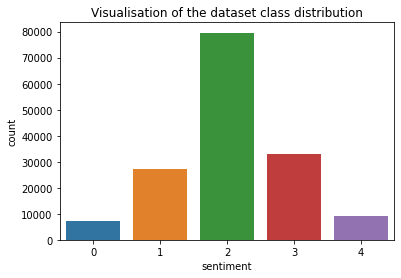

In [5]:
plot_class_distribution(df_train["sentiment"])

# 2- Data pre-processing

### Data cleaning 

In [6]:
df_train = data_cleaning(df_train)
df_submission = data_cleaning(df_submission)

### Transformation to TF-IDF features

In [7]:
# best_par = return_best_tfidf(df_train)

In [8]:
# X_TfIdf = Tfidf_transformation(df_train,ngram_range=(1,1))
# X_TfIdf = Tfidf_transformation(df_train,ngram_range= best_par["tfidf__ngram_range"])

### Transformation to word2Vec features using gensim

In [9]:
# X_word2Vec = load_pkl("./X_word2Vec.pkl")
# X_word2Vec = word2Vec_transform(df_train,True)

# 3- Data partitionning

### Create sets using the original data

In [10]:
X_train,X_val,X_test,y_train,y_val,y_test = data_partitioning(df_train["review"].values,df_train["sentiment"].values,test_size=0.3)

Overall class distribution in this dataset
2    55861
3    22965
1    19061
4     6354
0     5000
dtype: int64
2    11880
3     4969
1     4162
4     1387
0     1011
dtype: int64

X_train has shape: (109241,)
y_train has shape: (109241,)
X_val has shape: (23409,)
y_val has shape: (23409,)
X_test has shape: (23410,)
y_test has shape: (23410,)


### Create sets to be used when converted into TFIDF features

In [11]:
# X_train_TfIdf,X_val_TfIdf,X_test_TfIdf,y_train_TfIdf,y_val_TfIdf,y_test_TfIdf = data_partitioning(X_TfIdf,df_train["sentiment"].values,test_size=0.3)

### Create sets to be used when converted into Word2Vec features

In [12]:
# X_train_word2Vec,X_val_word2Vec,X_test_word2Vec,y_train_word2Vec,y_val_word2Vec,y_test_word2Vec= data_partitioning(X_word2Vec,df_train["sentiment"].values,test_size=0.3)

### Create sets to be used when converted into Word2Vec features

In [13]:
X_train_bert,X_val_bert,X_test_bert,y_train_bert,y_val_bert,y_test_bert = data_partitioning(df_train["review"].values,df_train["sentiment"].values,test_size=0.3)

Overall class distribution in this dataset
2    55719
3    23034
1    19067
4     6482
0     4939
dtype: int64
2    11979
3     4914
1     4100
4     1377
0     1039
dtype: int64

X_train has shape: (109241,)
y_train has shape: (109241,)
X_val has shape: (23409,)
y_val has shape: (23409,)
X_test has shape: (23410,)
y_test has shape: (23410,)


# 4- Inference step using Logistic regression

### Sentiment prediction using TF-IDF embeddings

In [14]:
# X_train_TfIdf,X_test_TfIdf,tsvd = apply_TSVD(X_train_TfIdf,X_test_TfIdf)    

In [15]:
# LR_predict(X_train_TfIdf,y_train_TfIdf,X_test_TfIdf,y_test_TfIdf)

### Sentiment prediction using Word2Vec embeddings

In [16]:
# LR_predict(X_train_word2Vec,y_train_word2Vec,X_test_word2Vec,y_test_word2Vec)

# 5- Inference step using Deep Learning

### Data encoding and embedding layer creation with Word2vec Transfer Learning

In [17]:
EMBEDDING_DIM,MAX_SEQUENCE_LENGTH,MAX_VOCAB_SIZE,w2v_model,embedding_matrix,X_train,X_val,X_test,X_submission = load_pretrained_embedding_model(df_train,
                                                                                                                                   df_submission, 
                                                                                                                                   X_train, 
                                                                                                                                   X_val,
                                                                                                                                   X_test,
                                                                                                                                   EMBEDDING_DIM = 300, 
                                                                                                                                   model = 'word2vec-google-news-300')

Maximum sentence lenght:  52
Found 19284 unique tokens in the dataset.
Loading word vectors from server...
Loading word vectors from local saved file...
Shape of X_train data tensor: (109241, 52)
Shape of X_val data tensor: (23409, 52)
Shape of X_test data tensor: (23410, 52)
Shape of X_submission data tensor: (66292, 52)
Filling pre-trained embeddings...
The final embedding matrix has shape:  (19285, 300)


In [18]:
embedding_layer = Embedding(MAX_VOCAB_SIZE,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

## 1- Long-Short-Term-Memory (LSTM)

In [19]:
def simple_LSTM_model_multiclass(embedding_layer):
    simple_LSTM_model_multiclass = Sequential()
    simple_LSTM_model_multiclass.add(embedding_layer)
    simple_LSTM_model_multiclass.add(LSTM(128))
    simple_LSTM_model_multiclass.add(Dense(5, activation='softmax'))
    simple_LSTM_model_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                         optimizer=Adam(lr=1e-3),
                                         metrics=['accuracy'])
    simple_LSTM_model_multiclass.summary()
    return simple_LSTM_model_multiclass,"simple_LSTM_model_multiclass"

model, model_name = simple_LSTM_model_multiclass(embedding_layer) 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 300)           5785500   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 5)                 645       
Total params: 6,005,793
Trainable params: 220,293
Non-trainable params: 5,785,500
_________________________________________________________________


In [20]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 10, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

Epoch 1/10
853/854 [============================>.] - ETA: 0s - loss: 1.0415 - accuracy: 0.5810

KeyboardInterrupt: 

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 2- BiLSTM with a Dense Layer and Dropout

In [ ]:
def simple_biLSTM_model_multiclass(embedding_layer):
    simple_biLSTM_model_multiclass = Sequential()
    simple_biLSTM_model_multiclass.add(embedding_layer)
    simple_biLSTM_model_multiclass.add(Bidirectional(LSTM(128)))
    simple_biLSTM_model_multiclass.add(Dense(128, activation='relu'))
    simple_biLSTM_model_multiclass.add(Dropout(0.5))
    simple_biLSTM_model_multiclass.add(Dense(5, activation='softmax'))
    simple_biLSTM_model_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    simple_biLSTM_model_multiclass.summary()
    return simple_biLSTM_model_multiclass,"simple_biLSTM_model_multiclass"

model, model_name = simple_biLSTM_model_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 11, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 3- Multiple layer lstm
 

In [27]:
def multi_layer_lstm_multiclass(embedding_layer):
    multi_layer_lstm_multiclass = Sequential()
    multi_layer_lstm_multiclass.add(embedding_layer)
    multi_layer_lstm_multiclass.add(Bidirectional(LSTM(128, return_sequences=True)))
    keras.layers.Dropout(0.5)
    multi_layer_lstm_multiclass.add(GlobalMaxPool1D())
    keras.layers.Dropout(0.5)
    multi_layer_lstm_multiclass.add(Dense(5, activation='softmax'))
    multi_layer_lstm_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    multi_layer_lstm_multiclass.summary()
    return multi_layer_lstm_multiclass,"multi_layer_lstm_multiclass"

model, model_name = multi_layer_lstm_multiclass(embedding_layer)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 52, 300)           5785500   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 52, 256)           439296    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 1285      
Total params: 6,226,081
Trainable params: 440,581
Non-trainable params: 5,785,500
_________________________________________________________________


Epoch 1/13
854/854 [==============================] - 16s 16ms/step - loss: 1.0531 - accuracy: 0.5828 - val_loss: 0.8808 - val_accuracy: 0.6395
Epoch 2/13
854/854 [==============================] - 12s 15ms/step - loss: 0.8686 - accuracy: 0.6446 - val_loss: 0.8546 - val_accuracy: 0.6498
Epoch 3/13
854/854 [==============================] - 13s 15ms/step - loss: 0.8212 - accuracy: 0.6653 - val_loss: 0.8376 - val_accuracy: 0.6547
Epoch 4/13
854/854 [==============================] - 13s 15ms/step - loss: 0.7875 - accuracy: 0.6800 - val_loss: 0.8168 - val_accuracy: 0.6650
Epoch 5/13
854/854 [==============================] - 13s 15ms/step - loss: 0.7507 - accuracy: 0.6960 - val_loss: 0.8079 - val_accuracy: 0.6688
Epoch 6/13
854/854 [==============================] - 13s 15ms/step - loss: 0.7162 - accuracy: 0.7110 - val_loss: 0.8001 - val_accuracy: 0.6713
Epoch 7/13
854/854 [==============================] - 13s 15ms/step - loss: 0.6855 - accuracy: 0.7244 - val_loss: 0.7995 - val_accuracy:

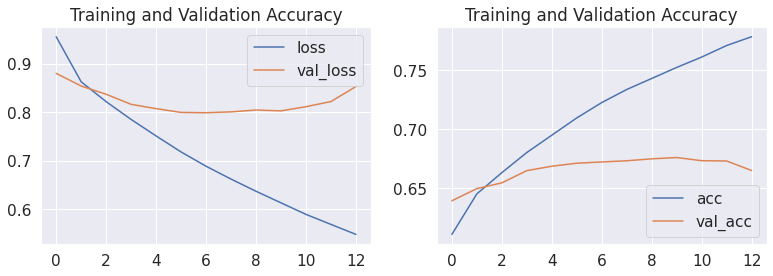

In [28]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

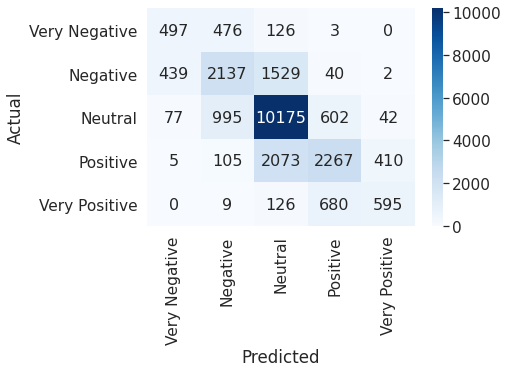

              precision    recall  f1-score   support

           0       0.49      0.45      0.47      1102
           1       0.57      0.52      0.54      4147
           2       0.73      0.86      0.79     11891
           3       0.63      0.47      0.54      4860
           4       0.57      0.42      0.48      1410

    accuracy                           0.67     23410
   macro avg       0.60      0.54      0.56     23410
weighted avg       0.66      0.67      0.66     23410



In [29]:
generate_pred(model,X_test,y_test)

In [30]:
submission = generate_submission(model,X_submission,model_name)
submission

,PhraseId,Sentiment
0,156061,2
1,156062,2
2,156063,2
3,156064,2
4,156065,2
...,...,...
66287,222348,0
66288,222349,0
66289,222350,1
66290,222351,1


## 4- Convolutional Neural network


In [ ]:
def simple_CNN_multiclass(embedding_layer):
    simple_CNN_multiclass = Sequential()
    simple_CNN_multiclass.add(embedding_layer)
    simple_CNN_multiclass.add(Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1))
    simple_CNN_multiclass.add(GlobalMaxPool1D())
    simple_CNN_multiclass.add(Dense(256, activation='relu'))
    simple_CNN_multiclass.add(Dense(5, activation='softmax'))
    simple_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    simple_CNN_multiclass.summary()
    return simple_CNN_multiclass,"simple_CNN_multiclass"

model, model_name = simple_CNN_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 5- ELABORATED CNN WITH PARALLEL LAYERS AND DROPOUT
 

In [ ]:
def parallelized_CNN_multiclass(embedding_layer):
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    tweet_encoder = embedding_layer(input_)
    bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
    bigram_branch = GlobalMaxPool1D()(bigram_branch)
    trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
    trigram_branch = GlobalMaxPool1D()(trigram_branch)
    fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
    fourgram_branch = GlobalMaxPool1D()(fourgram_branch)
    fifthgram_branch = Conv1D(filters=100, kernel_size=5, padding='valid', activation='relu', strides=1)(tweet_encoder)
    fifthgram_branch = GlobalMaxPool1D()(fifthgram_branch)
    merged = concatenate([bigram_branch, trigram_branch,fourgram_branch,fifthgram_branch], axis=1)
    merged = Dropout(0.5)(merged)
    merged = Dense(5)(merged)
    output = Activation('softmax')(merged)
    parallelized_CNN_multiclass = Model(inputs=[input_], outputs=[output])

    parallelized_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    parallelized_CNN_multiclass.summary()
    return parallelized_CNN_multiclass,"parallelized_CNN_multiclass"

model, model_name = parallelized_CNN_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

## 6- Hybrid model: CNN-LSTM

In [ ]:
def hybrid_LSTM_CNN_multiclass(embedding_layer):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
    embedded_sequences = embedding_layer(sequence_input)
    drop_out_1 = Dropout(0.5, name='drop_out_1')(embedded_sequences)
    biLSTM_1 = Bidirectional(LSTM(60, return_sequences=True))(embedded_sequences)
    conv_1 = Conv1D(128, 2, activation='relu', name='conv_1')(biLSTM_1)
    gmp_1 = GlobalMaxPool1D(name='gmp_1')(conv_1)
    conv_2 = Conv1D(128, 3, activation='relu', name='conv_2')(biLSTM_1)
    gmp_2 = GlobalMaxPool1D(name='gmp_2')(conv_2)
    conv_3 = Conv1D(128, 4, activation='relu', name='conv_3')(biLSTM_1)
    gmp_3 = GlobalMaxPool1D(name='gmp_3')(conv_3)

    concat = concatenate([gmp_1,gmp_2,gmp_3])
    # concat = concatenate([gmp_1,gmp_2])

    drop_out_2 = Dropout(0.5, name='drop_out_2')(concat)
    mp_dense = Dense(64, activation='relu', name='mp_dense')(drop_out_2)
    drop_out_3 = Dropout(0.5, name='drop_out_2')(mp_dense)
    
    preds = Dense(5, activation='softmax', name='preds')(mp_dense)
    hybrid_LSTM_CNN_multiclass = Model(sequence_input, preds)

    hybrid_LSTM_CNN_multiclass.compile(loss='categorical_crossentropy', 
#                                          optimizer='adam', 
                                           optimizer=Adam(lr=1e-3),
                                           metrics=['accuracy'])
    
    hybrid_LSTM_CNN_multiclass.summary()
    return hybrid_LSTM_CNN_multiclass,"hybrid_LSTM_CNN_multiclass"

model, model_name = hybrid_LSTM_CNN_multiclass(embedding_layer)

In [ ]:
model = train_deep_model(model,
                        X_train,y_train, 
                        X_val, y_val,
                        BATCH_SIZE = 128, 
                        EPOCHS = 13, 
                        plot=True,
                        callback=True,
                        model_name= model_name )

In [ ]:
generate_pred(model,X_test,y_test)

In [ ]:
submission = generate_submission(model,X_submission,model_name)
submission

# TRANSFORMERS

In [ ]:
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def build_model(bert_layer, max_len=MAX_SEQUENCE_LENGTH):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary()
    return model, "bert_model"

In [ ]:
# train_input = bert_encode(X_train.values, tokenizer, max_len=150)
# val_input = bert_encode(X_val.values, tokenizer, max_len=150)
# test_input = bert_encode(X_test.values, tokenizer, max_len=150)
# sub_input = bert_encode(df_submission.review.values, tokenizer, max_len=150)

# new_model = tf.keras.models.load_model('../input/test-models/model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# new_model.summary()

In [ ]:
train_input = bert_encode(X_train_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
val_input = bert_encode(X_val_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
test_input = bert_encode(X_test_bert, tokenizer, max_len=MAX_SEQUENCE_LENGTH)
sub_input = bert_encode(df_submission.review.values, tokenizer, max_len=MAX_SEQUENCE_LENGTH)

In [ ]:
model,model_name = build_model(bert_layer, max_len=MAX_SEQUENCE_LENGTH)

# bert_model = tf.keras.models.load_model('../input/test-models/model.h5',custom_objects={'KerasLayer':hub.KerasLayer})
# bert_model.summary()

In [ ]:
model = train_bert_model(model,
                        train_input,y_train_bert, 
                        val_input,y_val_bert,
                        BATCH_SIZE = 50, 
                        EPOCHS = 8, 
                        plot=True,
                        callback=True,
                        model_name= model_name)

In [ ]:
generate_pred(model,test_input,y_test_bert)

In [ ]:
submission = generate_submission(model,sub_input,model_name)
submission